In [ ]:

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-06-04 06:11:55--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  45.0MB/s    in 36s     

2020-06-04 06:12:31 (44.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



Using TensorFlow backend.


 1    6252
-1    4210
 0    1583
Name: sent_score, dtype: int64


2020-06-04 06:12:36,486 : INFO : loading projection weights from https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz


['itali', 'prove', 'pc', 'sometim', 'danger', 'note', 'covid', 'case', 'soar', 'sadli', 'idiot', 'hug', 'chines', 'day', 'meanwhil', 'chines', 'gov', 'use', 'propaganda', 'corona', 'chineseviru']


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-04 06:12:38,654 : INFO : loaded (50000, 300) matrix from https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz


(12045, 30)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           15000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               129000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8672 samples, validate on 2168 samples
Epoch 1/100
8672/8672 [==============================] - 57s 7ms/step - loss: 0.3921 - accuracy: 0.1463 - val_loss: -0.1716 - val_accuracy: 0.3086
Epoch 2/100
8672/8672 [==============================] - 59s 7ms/step - loss: -4.1581 - accuracy: 0.3953 - val_loss: -4.0597 - val_accuracy: 0.3399
Epoch 3/100
8672/8672 [==============================] - 57s 7ms/step - loss: -14.4928 - accuracy: 0.4765 - val_loss: -8.2734 - val_accuracy: 0.3967
Epoch 4/100
8672/8672 [==============================] - 58s 7ms/step - loss: -26.1491 - accuracy: 0.5092 - val_loss: -11.9439 - val_accuracy: 0.4059
Epoch 5/100
8672/8672 [==============================] - 61s 7ms/step - loss: -38.0972 - accuracy: 0.5212 - val_loss: -16.7362 - val_accuracy: 0.4253
Epoch 6/100
8672/8672 [==============================] - 62s 7ms/step - loss: -50.3199 - accuracy: 0.5401 - val_loss: -18.9603 - val_accuracy: 0.4184
Epoch 7/100
8672/8672 [==============================] - 6

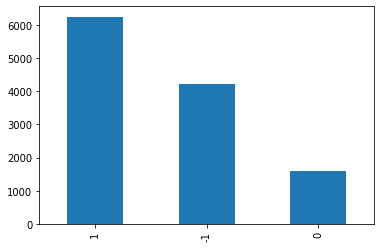

In [ ]:

import gensim.models.keyedvectors as word2vec 
from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Conv1D, Dense, Flatten, MaxPooling1D, Dropout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report


import logging
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array


logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)


np.random.seed(24)

tweetsData = pd.read_csv('coronatweets.csv') 
tweetsData.head()


tweets = tweetsData['full_text']
labels = tweetsData['sent_score']


labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())


tkr = RegexpTokenizer('[a-zA-Z@]+')

tweets_split = []

for i, line in enumerate(tweets):
   tweet = str(line).lower().split()
   tweet = tkr.tokenize(str(tweet))
   tweets_split.append(tweet)

print(tweets_split[1])



w2vModel = word2vec.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=50000)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)


maxlentweet = 30

X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)


embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])


lstm_out = 150

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))
model.add(LSTM(units=lstm_out))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())




X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)


batch_size = 40
history=model.fit(X_train, Y_train, epochs=100, verbose=1, batch_size=batch_size, validation_split=0.2)     


score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)


from matplotlib import pyplot
from numpy import array

#pyplot.plot(history.history['loss'])
#pyplot.plot(history.history['val_loss'])
#pyplot.title('model train vs validation loss')
#pyplot.ylabel('loss')
#pyplot.xlabel('epoch')
#pyplot.ylim(-4, 0)
#pyplot.xlim(0, 10)

#pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()




In [ ]:
print(acc)

0.4705394208431244
